In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import cv2
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


- motionsDetector_state_dict002:<br>
acc of uni valid dataset :  79.33333333333333<br>
acc of RAF dataset :  78.165<br>
acc of FER dataset :  80.37666666666668<br>
- emotionsDetector_tranfer_learning_state_dict002(raf_trans_learn):<br>
acc of uni valid dataset :  70.83333333333333<br>
acc of RAF dataset :  72.63666666666667

In [2]:
from myModel import EmotionsDetector

model = EmotionsDetector()
model.load_state_dict(torch.load("C:/LMU/python/SEP_DLCV/Final_project/last_work/models/blumenDetector_state_dict002.pth"))
model.to(device)
model.eval()  

EmotionsDetector(
  (conv1_1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

Code Breakdown:<br>

- Class Names: This list defines the emotions the model predicts (anger, disgust, etc.).<br>
Hook Class: This class helps capture the output (forward_out) and gradient (backward_out) from the specified layer (final_layer).
Prediction:<br>
The code preprocesses the image, feeds it through the model, and gets the predicted emotion class and its name.<br>
It then creates a one-hot encoded vector representing the predicted class.<br>
- Backpropagation and Grad-CAM Calculation:<br>
Backpropagation is performed using one_hot_output to get the gradients for the final layer.<br>
gradients store the average gradients across spatial dimensions (height and width).<br>
feature_maps store the output of the final layer (before activation).<br>
The Grad-CAM is calculated by multiplying weights (average gradients) with feature_maps element-wise, summing across channels, and normalizing the result (cam).<br>
- Resizing and Normalization:<br>
cam is resized to match the original image size (likely 64x64).<br>
It's normalized to a range of 0 to 1 for visualization.

In [3]:

img_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/models/img.jpg"


def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess(img).unsqueeze(0)  
    return img

### Gradient-based Class Activitation Mapping

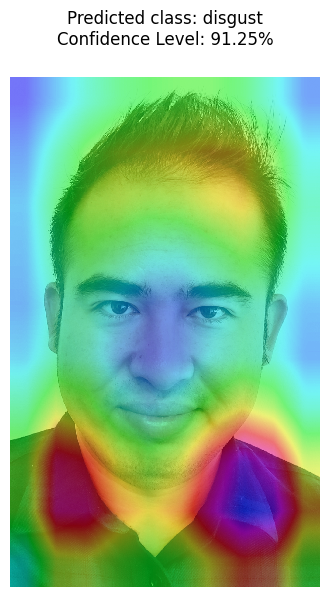

In [4]:
class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

class Hook():
    def __init__(self):
        self.hook_forward = None
        self.hook_backward = None
        self.forward_out = None
        self.backward_out = None

    def hook_fn_forward(self, module, input, output):
        self.forward_out = output

    def hook_fn_backward(self, module, grad_input, grad_output):
        self.backward_out = grad_output[0] 

    def register_hook(self, module):
        self.hook_forward = module.register_forward_hook(self.hook_fn_forward)
        self.hook_backward = module.register_full_backward_hook(self.hook_fn_backward)

    def unregister_hook(self):
        self.hook_forward.remove()
        self.hook_backward.remove()

final_layer = model.conv4_3 
hook = Hook()
hook.register_hook(final_layer)

img_tensor = preprocess_image(img_path)
logits = model(img_tensor)
probabilities = F.softmax(logits, dim=1)

# Get the top probability and its corresponding class index
top_prob, predicted_class = torch.max(probabilities, dim=1)  # Returns a tuple

predicted_class_idx = predicted_class.item()
predicted_class_name = class_names[predicted_class_idx]

one_hot_output = torch.FloatTensor(1, probabilities.shape[1]).zero_()
one_hot_output[0][predicted_class_idx] = 1
logits.backward(one_hot_output, retain_graph=True)

gradients = hook.backward_out
feature_maps = hook.forward_out

hook.unregister_hook()

weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
cam = torch.sum(weights * feature_maps, dim=1, keepdim=True)
cam = cam.clamp(min=0).squeeze() 

cam -= cam.min()
cam /= cam.max()
cam = cam.cpu().detach().numpy()
cam = cv2.resize(cam, (64, 64))

original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Resize CAM to match the original image dimensions
cam_resized = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))

# Normalize CAM to [0, 255]
cam_normalized = (cam_resized * 255).astype(np.uint8)

# Apply colormap (jet) to CAM
cam_colored = cv2.applyColorMap(cam_normalized, cv2.COLORMAP_HSV)

# Convert original image to uint8
original_img_uint8 = original_img.astype(np.uint8)

# Combine original image and CAM using weighted addition
combined_img = cv2.addWeighted(original_img_uint8, 0.5, cam_colored, 0.5, 0)

# Convert top probability to percentage (assuming probabilities are between 0 and 1)
confidence_percentage = top_prob.item() * 100

# Display combined image
plt.matshow(combined_img)
plt.title(f'Predicted class: {predicted_class_name}'+'\n'+f'Confidence Level: {confidence_percentage:.2f}%')
plt.axis('off')
plt.show()

### Bounding box for predicted class

Bounding box coordinates: [0, 0, 2316, 3088]


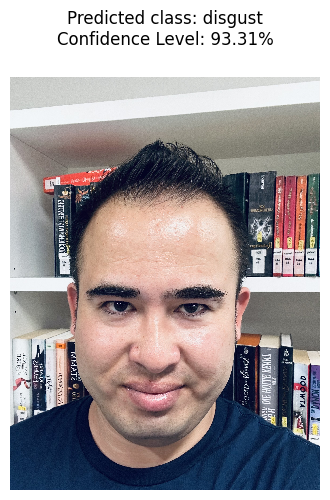

In [7]:
import cv2
import numpy as np

def threshold_cam(cam, threshold):
    """
    Applies a threshold to the CAM and returns the thresholded version.

    Args:
      cam: A NumPy array representing the CAM.
      threshold: A float value between 0 and 1 representing the threshold proportion.

    Returns:
      A NumPy array representing the thresholded CAM.
    """
    thresholded_cam = np.where(cam > threshold * cam.max(), 1, 0)
    return thresholded_cam


thresholded_cam = threshold_cam(cam, 0.2)


def get_segmentation_map(thresholded_cam):
  """
  Converts the thresholded CAM into a binary segmentation map.

  Args:
      thresholded_cam: A NumPy array representing the thresholded CAM.

  Returns:
      A NumPy array representing the segmentation map (0: background, 1: foreground).
  """
  segmentation_map = thresholded_cam.astype(np.uint8)
  return segmentation_map


segmentation_map = get_segmentation_map(thresholded_cam)


def get_bounding_box(segmentation_map):
  """
  Finds the largest connected component in the segmentation map and returns its bounding box.

  Args:
      segmentation_map: A NumPy array representing the segmentation map.

  Returns:
      A list containing the coordinates of the bounding box for the largest component 
      or None if no component is found.
  """

  # Ensure segmentation_map is in uint8 format
  segmentation_map = segmentation_map.astype(np.uint8)

  contours, _ = cv2.findContours(segmentation_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if not contours:
    return None
  # Find the largest contour
  largest_contour = max(contours, key=cv2.contourArea)
  # Get bounding box of the largest contour
  x, y, w, h = cv2.boundingRect(largest_contour)
  return [x, y, x + w, y + h]

#img_path = "C:/LMU/python/SEP_DLCV/Final_project/data_model/project/obama-855.jpg"
cam = combined_img
threshold = 0.2
thresholded_cam = threshold_cam(cam_resized, threshold)
segmentation_map = get_segmentation_map(thresholded_cam)
bounding_box = get_bounding_box(segmentation_map)
print("Bounding box coordinates:", bounding_box)

# Define the function to draw bounding box on the original image
def draw_bounding_box(image, bounding_box):
    x1, y1, x2, y2 = bounding_box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Draw rectangle
    return image


# Load the original image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Draw bounding box on the original image
image_with_box = draw_bounding_box(original_img.copy(), bounding_box)

# Display combined image
plt.matshow(image_with_box)
plt.title(f'Predicted class: {predicted_class_name}'+'\n'+f'Confidence Level: {confidence_percentage:.2f}%')
plt.axis('off')
plt.show()

### validation set confusion matrix from uni(600 images) 

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB channels
])

DS_path = "C:/LMU/python/SEP_DLCV/Final_project/data_model/project/project_datasets/unzipped/valid"

test_data = datasets.ImageFolder(root=DS_path,
                                  transform=transform)

test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=8, 
                              num_workers=4, 
                              shuffle=True) 
img, label = next(iter(test_dataloader))
print(f"Train batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Train batch: Image shape: torch.Size([8, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


In [8]:
# Iterate over your test loader
all_preds = torch.tensor([], dtype=torch.long)  # Empty tensor to store all predictions
all_labels = torch.tensor([], dtype=torch.long)  # Empty tensor to store all labels

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU/CPU)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest probability

        all_preds = torch.cat((all_preds, predicted), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

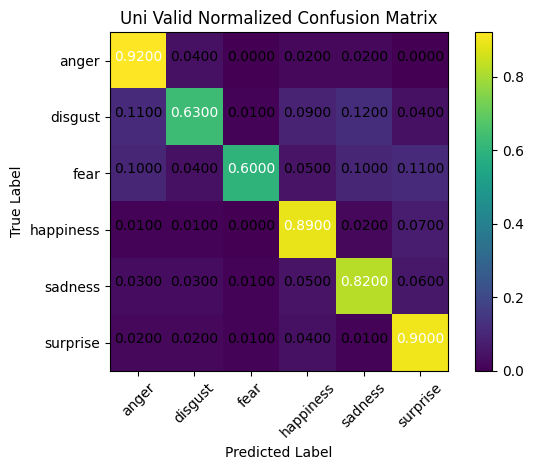

acc of uni valid dataset :  79.33333333333333


In [11]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

# Your data loading and model prediction code...

conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

normalized_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create plot using Matplotlib
plt.imshow(normalized_matrix, interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Uni Valid Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations for each cell
thresh = normalized_matrix.max() / 2.
for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    plt.text(j, i, "{:0.4f}".format(normalized_matrix[i, j]),
             horizontalalignment="center",
             color="white" if normalized_matrix[i, j] > thresh else "black")

# Set x-axis and y-axis labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.show()
print("acc of uni valid dataset : ",(92 + 63 + 60 + 89 + 82 + 90)/6)


### RAF set confusion matrix

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB channels
])

DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/EmotionsDetector/dss/RAF_dataset"

test_data = datasets.ImageFolder(root=DS_path,
                                  transform=transform)

test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=64, 
                              num_workers=4, 
                              shuffle=True) 
img, label = next(iter(test_dataloader))
print(f"Train batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Train batch: Image shape: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


In [35]:
# Iterate over your test loader
all_preds = torch.tensor([], dtype=torch.long)  # Empty tensor to store all predictions
all_labels = torch.tensor([], dtype=torch.long)  # Empty tensor to store all labels

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU/CPU)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest probability

        all_preds = torch.cat((all_preds, predicted), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

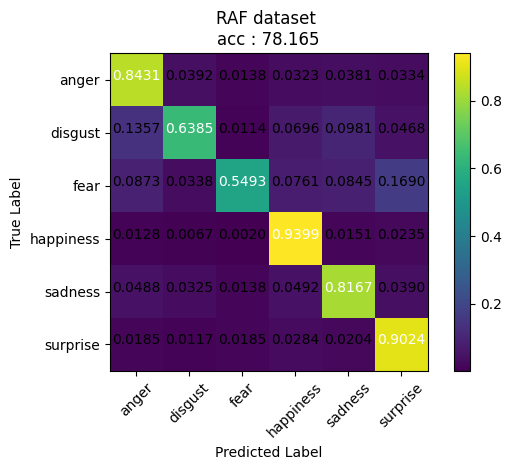

acc of RAF dataset :  78.165


In [37]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

# Your data loading and model prediction code...

conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

normalized_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create plot using Matplotlib
plt.imshow(normalized_matrix, interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()
plt.title("RAF dataset \nacc : 78.165")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations for each cell
thresh = normalized_matrix.max() / 2.
for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    plt.text(j, i, "{:0.4f}".format(normalized_matrix[i, j]),
             horizontalalignment="center",
             color="white" if normalized_matrix[i, j] > thresh else "black")

# Set x-axis and y-axis labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.show()
print("acc of RAF dataset : ",(84.31 + 63.85 + 54.93 + 93.99 + 81.67 + 90.24)/6)


### FER set confusion matrix

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB channels
])

DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/EmotionsDetector/dss/FER_dataset"

test_data = datasets.ImageFolder(root=DS_path,
                                  transform=transform)

test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=64, 
                              num_workers=4, 
                              shuffle=True) 
img, label = next(iter(test_dataloader))
print(f"Train batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Train batch: Image shape: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


In [30]:
# Iterate over your test loader
all_preds = torch.tensor([], dtype=torch.long)  # Empty tensor to store all predictions
all_labels = torch.tensor([], dtype=torch.long)  # Empty tensor to store all labels

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU/CPU)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest probability

        all_preds = torch.cat((all_preds, predicted), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

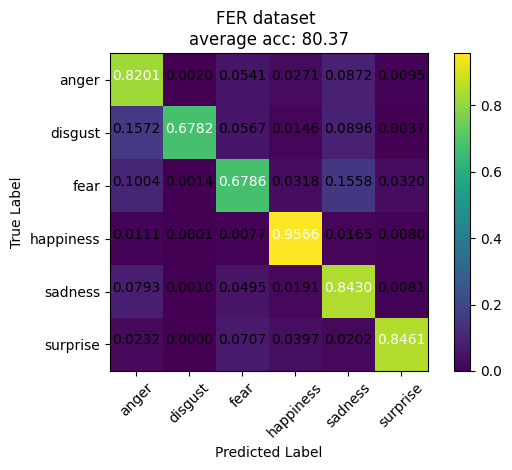

acc of FER dataset :  80.37666666666668


In [31]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

# Your data loading and model prediction code...

conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

normalized_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create plot using Matplotlib
plt.imshow(normalized_matrix, interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()
plt.title("FER dataset \naverage acc: 80.37")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations for each cell
thresh = normalized_matrix.max() / 2.
for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    plt.text(j, i, "{:0.4f}".format(normalized_matrix[i, j]),
             horizontalalignment="center",
             color="white" if normalized_matrix[i, j] > thresh else "black")

# Set x-axis and y-axis labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.show()
print("acc of FER dataset : ",(82.01 + 67.82 + 67.86 + 95.66 + 84.30 + 84.61)/6)


### TFEID set confusion matrix

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB channels
])

DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/EmotionsDetector/dss/TFEID"

test_data = datasets.ImageFolder(root=DS_path,
                                  transform=transform)

test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=64, 
                              num_workers=4, 
                              shuffle=True) 
img, label = next(iter(test_dataloader))
print(f"Train batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Train batch: Image shape: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


In [20]:
# Iterate over your test loader
all_preds = torch.tensor([], dtype=torch.long)  # Empty tensor to store all predictions
all_labels = torch.tensor([], dtype=torch.long)  # Empty tensor to store all labels

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU/CPU)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest probability

        all_preds = torch.cat((all_preds, predicted), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

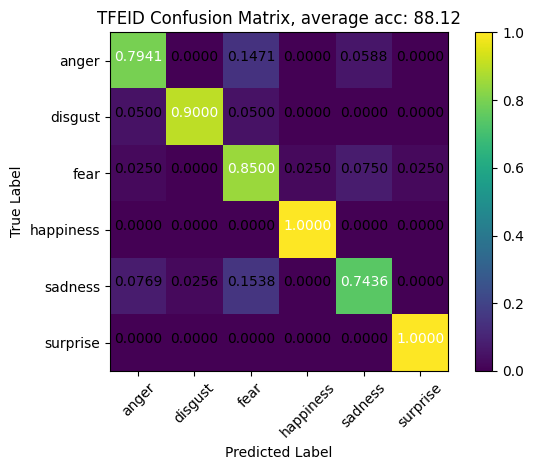

acc of TFEID dataset :  88.12833333333333


In [21]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

# Your data loading and model prediction code...

conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

normalized_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create plot using Matplotlib
plt.imshow(normalized_matrix, interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()
plt.title("TFEID Confusion Matrix, average acc: 88.12")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations for each cell
thresh = normalized_matrix.max() / 2.
for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    plt.text(j, i, "{:0.4f}".format(normalized_matrix[i, j]),
             horizontalalignment="center",
             color="white" if normalized_matrix[i, j] > thresh else "black")

# Set x-axis and y-axis labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.show()
print("acc of TFEID dataset : ",(79.41 + 90.00 + 85.00 + 100.00 + 74.36 + 100.00)/6)


### CK+ set confusion matrix

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB channels
])

DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/EmotionsDetector/dss/CK+"

test_data = datasets.ImageFolder(root=DS_path,
                                  transform=transform)

test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=64, 
                              num_workers=4, 
                              shuffle=True) 
img, label = next(iter(test_dataloader))
print(f"Train batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Train batch: Image shape: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


In [23]:
# Iterate over your test loader
all_preds = torch.tensor([], dtype=torch.long)  # Empty tensor to store all predictions
all_labels = torch.tensor([], dtype=torch.long)  # Empty tensor to store all labels

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU/CPU)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest probability

        all_preds = torch.cat((all_preds, predicted), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

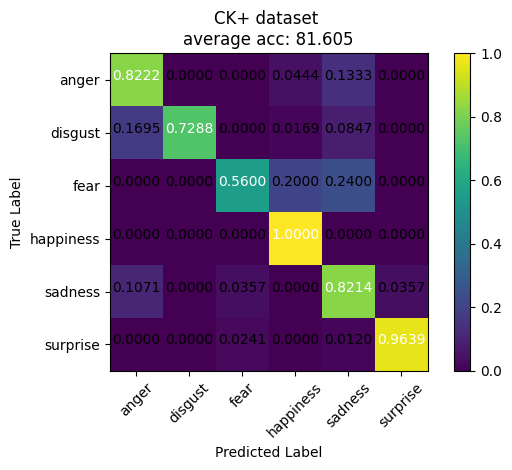

acc of CK+ dataset :  81.605


In [27]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

# Your data loading and model prediction code...

conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

normalized_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create plot using Matplotlib
plt.imshow(normalized_matrix, interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()
plt.title("CK+ dataset \naverage acc: 81.605")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations for each cell
thresh = normalized_matrix.max() / 2.
for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    plt.text(j, i, "{:0.4f}".format(normalized_matrix[i, j]),
             horizontalalignment="center",
             color="white" if normalized_matrix[i, j] > thresh else "black")

# Set x-axis and y-axis labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.show()
print("acc of CK+ dataset : ",(82.22 + 72.88 + 56.00 + 100.00 + 82.14 + 96.39)/6)
